In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import pdb


# Size of feature map in discriminator
NDF = 16
# Size of feature map in Generator
NGF = 16
# Size of latent vector z (size of generator input)
NZ = 100
# Size of mini-batch
BS = 64
# Learning rate for Adam optimizer
LR = 0.0002
# Momentum value for Adam optimizer
BETA1 = 0.5
# Number of epoch
NUMEPOCHS = 20
# Number of channels of image
NC = 3
# Folder path to save model
PATH = './models/DC2_CIFAR_'

os.mkdir('./models')

class Generator(nn.Module):
    """Build a Generative Network."""
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(NZ, NGF*8*4*4),
            nn.BatchNorm1d(NGF*8*4*4),
            nn.ReLU(inplace=True))
        
        self.main = nn.Sequential(          
            nn.ConvTranspose2d(NGF*8, NGF*4, 4, 2, 1),
            nn.BatchNorm2d(NGF*4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(NGF*4, NGF*2, 4, 2, 1),
            nn.BatchNorm2d(NGF*2),
            nn.ReLU(inplace=True),
        
            nn.ConvTranspose2d(NGF*2, NC, 4, 2, 1),
            nn.Tanh())
    
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, NGF*8, 4, 4)
        x = self.main(x)
        return x


class Discriminator(nn.Module):
    """Build a Discriminative Network."""
    
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(NC, NDF, 4, 2, 1),
            nn.LeakyReLU(0.2,inplace=True),
        
            nn.Conv2d(NDF, NDF*2, 4, 2, 1),
            nn.BatchNorm2d(NDF*2),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(NDF*2, NDF*4, 4, 2, 1),
            nn.BatchNorm2d(NDF*4),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.fc = nn.Sequential(
            nn.Linear(4*4*NDF*4, 1),
            nn.Sigmoid())

    def forward(self, img):
        x = self.main(img)
        x = x.view(-1, 4*4*NDF*4)
        x = self.fc(x)
        return x
    
        
def weights_init(m):
    layerName = m.__class__.__name__
    if layerName.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0.0)

    
def load_dataset(batchSize):
    """Load MNIST dataset."""
    transform = transforms.Compose(
        [transforms.Resize(32),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    trainset = dset.CIFAR10(root='./data', train=True, 
                            download=True, transform=transform)
    testset = dset.CIFAR10(root='./data', train=False,
                           download=True, transform=transform)
    trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                              shuffle=True, num_workers=2)
    testLoader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                             shuffle=True, num_workers=2)
    return trainLoader, testLoader

Files already downloaded and verified
Files already downloaded and verified
[0/20][0/782]	Loss_D = 1.3497	Loss_G = 0.8055	D(x) = 0.5035	D(G(z)) = 0.4752 / 0.4487
[0/20][50/782]	Loss_D = 0.7621	Loss_G = 1.4507	D(x) = 0.7828	D(G(z)) = 0.3005 / 0.2324
[0/20][100/782]	Loss_D = 0.5576	Loss_G = 1.8284	D(x) = 0.9184	D(G(z)) = 0.2314 / 0.1591
[0/20][150/782]	Loss_D = 0.4513	Loss_G = 1.6741	D(x) = 0.9710	D(G(z)) = 0.1719 / 0.1931
[0/20][200/782]	Loss_D = 0.4196	Loss_G = 2.0115	D(x) = 0.9828	D(G(z)) = 0.2195 / 0.1379
[0/20][250/782]	Loss_D = 0.4774	Loss_G = 2.0776	D(x) = 0.9644	D(G(z)) = 0.2004 / 0.1270
[0/20][300/782]	Loss_D = 0.5108	Loss_G = 1.8886	D(x) = 0.9835	D(G(z)) = 0.1260 / 0.1528
[0/20][350/782]	Loss_D = 0.6141	Loss_G = 1.8088	D(x) = 0.9192	D(G(z)) = 0.3059 / 0.1770
[0/20][400/782]	Loss_D = 0.6731	Loss_G = 1.7160	D(x) = 0.8631	D(G(z)) = 0.2603 / 0.1987
[0/20][450/782]	Loss_D = 0.6504	Loss_G = 1.3767	D(x) = 0.8570	D(G(z)) = 0.2328 / 0.2626
[0/20][500/782]	Loss_D = 0.7931	Loss_G = 1.8219

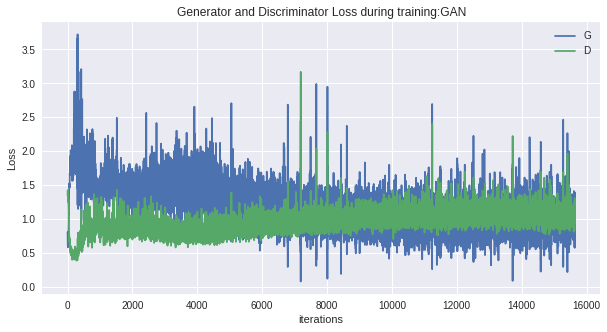

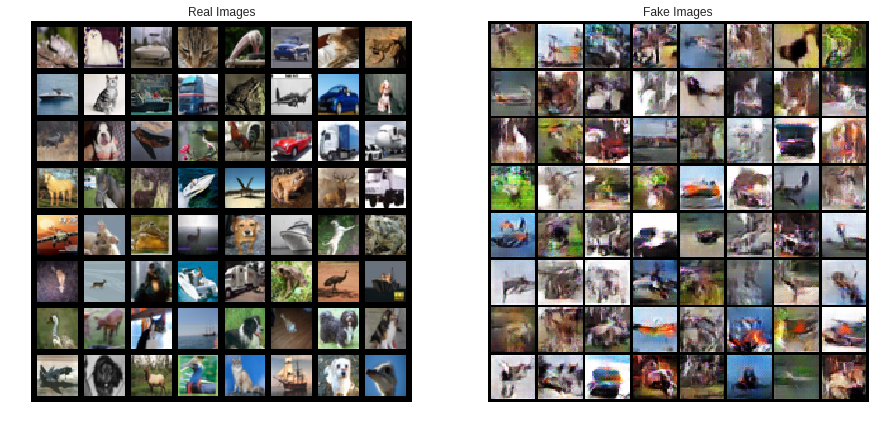

In [8]:
def train():
    """Build, train GAN."""    
    # Load dataset
    trainLoader, testLoader = load_dataset(BS)
    
    # Decide which device to use
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
    # # Create a batch of data
    # realBatch = next(iter(trainLoader))
    # assert len(realBatch[0]) == 128
    # assert len(realBatch[1]) == 128
    # assert realBatch[0].size() == torch.Size([128, 1, 32, 32])
    
    # Build and initialize the network
    netG = Generator().to(device)
    netD = Discriminator().to(device)
    netG.apply(weights_init)
    netD.apply(weights_init)
        
    # Initialize BCELoss function
    criterion = nn.BCELoss()
       
    # Create batch of latent vectors
    fixedNoise = torch.randn(64, NZ, device=device)
        
    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
    
    # Training loop
    imgList = []
    DLosses = []
    GLosses = []
    iters = 0
        
    for epoch in range(NUMEPOCHS):
        for i, data in enumerate(trainLoader, 0):
            # (1) Update Discriminator, maximize log(D(x)) + log(1 - D(G(z)))
            # Train with all-real images batch
            netD.zero_grad()
            realImg = data[0].to(device)
            batchSize = realImg.size(0)
            # Use soft labels
            realLabel = torch.full((batchSize,), 1, device=device)
            realLabel = realLabel + torch.randn(batchSize, device=device)/15
            output = netD(realImg).view(-1)
            errDReal = criterion(output, realLabel)
            errDReal.backward()
            D_x = output.mean().item()
             
            # Train with all-fake noises batch
            noise = torch.randn(batchSize, NZ, device=device)
            fakeImg = netG(noise)
            output = netD(fakeImg.detach()).view(-1)
            # Use soft labels
            fakeLabel = torch.full((batchSize,), 0, device=device)
            fakeLabel = fakeLabel + torch.rand(batchSize, device=device)/3
            errDFake = criterion(output, fakeLabel)
            errDFake.backward()
            D_G_z1 = output.mean().item()
            errD = errDReal + errDFake
            # Update Discriminator
            optimizerD.step()
              
            # (2) Update Generator, maximize log(D(G(z)))
            netG.zero_grad()
            output = netD(fakeImg).view(-1)
            errG = criterion(output, realLabel)
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update Generator
            optimizerG.step()
              
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D = %.4f\tLoss_G = %.4f\tD(x) = %.4f\tD(G(z)) = %.4f / %.4f' 
                      % (epoch, NUMEPOCHS, i, len(trainLoader), errD.item(), 
                         errG.item(), D_x, D_G_z1, D_G_z2))
            
            # Save loss for plotting later
            GLosses.append(errG.item())
            DLosses.append(errD.item())
             
            # Check how netG is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == NUMEPOCHS - 1) and 
                                      (i == len(trainLoader) - 1)):
                with torch.no_grad():
                    fake = netG(fixedNoise).detach().cpu()
                    imgList.append(vutils.make_grid(fake, padding=2, normalize=True))
            iters += 1
                
    # Save the network
    torch.save(netG.state_dict(), PATH+'netG.pt')
    torch.save(netD.state_dict(), PATH+'netD.pt')
    
    # Plot of Discriminator and Generator's losses  
    plt.figure(figsize=(10, 5))
    plt.title('Generator and Discriminator Loss during training:GAN')
    plt.plot(GLosses, label='G')
    plt.plot(DLosses, label='D')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig(PATH+'loss_GAN.png')
        
    # Real image versus fake images
    realBatch = next(iter(trainLoader))
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Real Images')
    plt.imshow(np.transpose(vutils.make_grid(realBatch[0].to(device)[:64], padding=5, 
                                    normalize=True).cpu(),(1,2,0)))
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Fake Images')
    plt.imshow(np.transpose(imgList[-1], (1,2,0)))
    plt.show()
    
    
# Train DCGAN normally 
train()

Files already downloaded and verified
Files already downloaded and verified
[0/20][0/782]	Loss_D = 1.3884	Loss_G = 0.7321	D(x) = 0.5060	D(G(z)) = 0.5036 / 0.4815
[0/20][50/782]	Loss_D = 0.6515	Loss_G = 1.6005	D(x) = 0.8240	D(G(z)) = 0.2621 / 0.2056
[0/20][100/782]	Loss_D = 0.4489	Loss_G = 2.0578	D(x) = 0.9530	D(G(z)) = 0.1961 / 0.1313
[0/20][150/782]	Loss_D = 0.5699	Loss_G = 2.0096	D(x) = 0.9365	D(G(z)) = 0.1855 / 0.1378
[0/20][200/782]	Loss_D = 0.5078	Loss_G = 1.8542	D(x) = 0.9460	D(G(z)) = 0.1331 / 0.1632
[0/20][250/782]	Loss_D = 0.6709	Loss_G = 1.6613	D(x) = 0.8867	D(G(z)) = 0.2918 / 0.2112
[0/20][300/782]	Loss_D = 0.7053	Loss_G = 1.9717	D(x) = 0.7760	D(G(z)) = 0.1888 / 0.1536
[0/20][350/782]	Loss_D = 0.5739	Loss_G = 1.8192	D(x) = 0.9299	D(G(z)) = 0.2468 / 0.1752
[0/20][400/782]	Loss_D = 0.7570	Loss_G = 2.1933	D(x) = 0.8413	D(G(z)) = 0.3392 / 0.1166
[0/20][450/782]	Loss_D = 0.9173	Loss_G = 1.7597	D(x) = 0.8076	D(G(z)) = 0.4333 / 0.1828
[0/20][500/782]	Loss_D = 0.6811	Loss_G = 1.8340

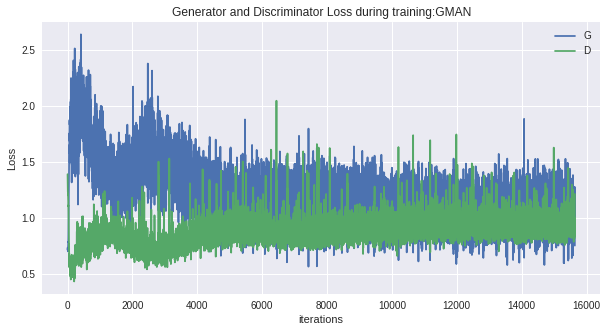

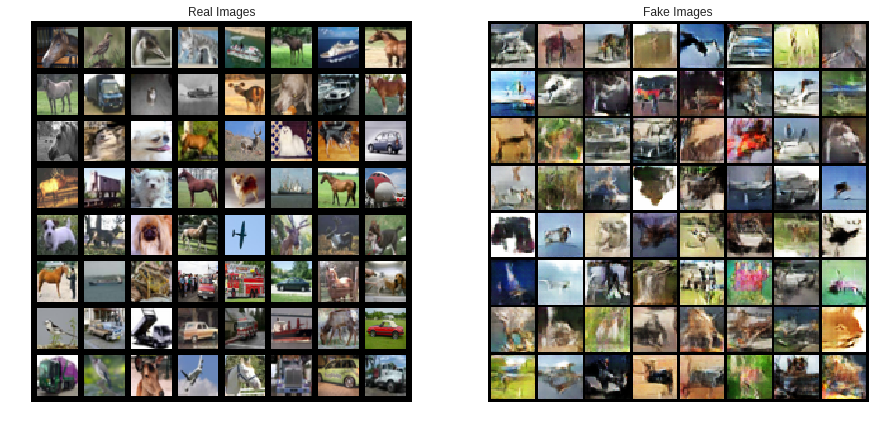

In [9]:
def train_with_GMAN():
    """Build, train GAN with GMAN."""    
    # Load dataset
    trainLoader, testLoader = load_dataset(BS)
    
    # Decide which device to use
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    #     # Create a batch of data
    #     realBatch = next(iter(trainLoader))
    #     assert len(realBatch[0]) == 128
    #     assert len(realBatch[1]) == 128
    #     assert realBatch[0].size() == torch.Size([128, 1, 32, 32])
    
    # Build and initialize the network
    MnetG = Generator().to(device)
    netD1 = Discriminator().to(device)
    netD2 = Discriminator().to(device)
    netD3 = Discriminator().to(device)
    netD4 = Discriminator().to(device)
    netD5 = Discriminator().to(device)
    
    MnetG.apply(weights_init)
    netD1.apply(weights_init)
    netD2.apply(weights_init)
    netD3.apply(weights_init)
    netD4.apply(weights_init)
    netD5.apply(weights_init)
    
    # Initialize BCELoss function
    criterion = nn.BCELoss()
    
    # Create batch of latent vectors
    fixedNoise = torch.randn(64, NZ, device=device)
    
    # Setup Adam optimizers for both G and D
    optimizerG = optim.Adam(MnetG.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD1 = optim.Adam(netD1.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD2 = optim.Adam(netD2.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD3 = optim.Adam(netD3.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD4 = optim.Adam(netD4.parameters(), lr=LR, betas=(BETA1, 0.999))
    optimizerD5 = optim.Adam(netD5.parameters(), lr=LR, betas=(BETA1, 0.999))
    
    # Training loop
    imgList = []
    DLosses = []
    GLosses = []
    iters = 0
    
    for epoch in range(NUMEPOCHS):
        for i, data in enumerate(trainLoader, 0):
            # (1) Update Discriminator, maximize log(D(x)) + log(1 - D(G(z)))
            # Train with all-real images batch
            netD1.zero_grad()
            netD2.zero_grad()
            netD3.zero_grad()
            netD4.zero_grad()
            netD5.zero_grad()
    
            optimizerD1.zero_grad()
            optimizerD2.zero_grad()  
            optimizerD3.zero_grad()
            optimizerD4.zero_grad()
            optimizerD5.zero_grad()
    
            realImg = data[0].to(device)
            batchSize = realImg.size(0)
            # Use soft labels
            realLabel = torch.full((batchSize,), 1, device = device)
            realLabel = realLabel + torch.randn(batchSize, device=device)/15
    
            noise = torch.randn(batchSize, NZ, device=device)
            fakeImg = MnetG(noise)
            # Use soft labels
            fakeLabel = torch.full((batchSize,), 0, device=device)
            fakeLabel = fakeLabel + torch.rand(batchSize, device=device)/3
    
            # Update all discriminators with batch of real and then fake data
            output1 = netD1(realImg).view(-1)
            errD1Real = criterion(output1, realLabel)
    
            output2 = netD2(realImg).view(-1)
            errD2Real = criterion(output2, realLabel)
    
            output3 = netD3(realImg).view(-1)
            errD3Real = criterion(output3, realLabel)
    
            output4 = netD4(realImg).view(-1)
            errD4Real = criterion(output4, realLabel)
    
            output5 = netD5(realImg).view(-1)
            errD5Real = criterion(output5, realLabel)
    
            output = (output1 + output2 + output3 + output4 + output5)/5
            D_x = output.mean().item()
    
            output1 = netD1(fakeImg.detach()).view(-1)
            errD1Fake = criterion(output1, fakeLabel)
            errD1 = errD1Real + errD1Fake
            errD1.backward()
            optimizerD1.step()
    
            output2 = netD2(fakeImg.detach()).view(-1)
            errD2Fake = criterion(output2, fakeLabel)
            errD2 = errD2Real + errD2Fake
            errD2.backward()
            optimizerD2.step()
    
            output3 = netD3(fakeImg.detach()).view(-1)
            errD3Fake = criterion(output3, fakeLabel)
            errD3 = errD3Real + errD3Fake
            errD3.backward()
            optimizerD3.step()
    
            output4 = netD4(fakeImg.detach()).view(-1)
            errD4Fake = criterion(output4, fakeLabel)
            errD4 = errD4Real + errD4Fake
            errD4.backward()
            optimizerD4.step()
    
            output5 = netD5(fakeImg.detach()).view(-1)
            errD5Fake = criterion(output5, fakeLabel)
            errD5 = errD5Real + errD5Fake
            errD5.backward()
            optimizerD5.step()
    
            output = 0.2*(output1+output2+output3+output4+output5)
            D_G_z1 = output.mean().item()
    
            errD = (errD1 + errD2 + errD3 + errD4 + errD5) / 5
    
            # (2) Update Generator, maximize log(D(G(z)))
            MnetG.zero_grad()
            output1 = netD1(fakeImg).view(-1)
            output2 = netD2(fakeImg).view(-1)
            output3 = netD3(fakeImg).view(-1)
            output4 = netD4(fakeImg).view(-1)
            output5 = netD5(fakeImg).view(-1)
    
            errG1 = criterion(output1, realLabel)
            errG2 = criterion(output2, realLabel)
            errG3 = criterion(output3, realLabel)
            errG4 = criterion(output4, realLabel)
            errG5 = criterion(output5, realLabel)
            errG = (errG1 + errG2 + errG3 + errG4 + errG5)/5
            output = (output1 + output2 + output3 + output4 + output5)/5 
            errG = criterion(output, realLabel)
            errG.backward()
            optimizerG.step()
            D_G_z2 = output.mean().item()
            # Update Generator
            #optimizerG.step()
    
    
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D = %.4f\tLoss_G = %.4f\tD(x) = %.4f\tD(G(z)) = %.4f / %.4f' 
                      % (epoch, NUMEPOCHS, i, len(trainLoader), errD.item(), 
                         errG.item(), D_x, D_G_z1, D_G_z2))  
    
            # Save loss for plotting later
            GLosses.append(errG.item())
            DLosses.append(errD.item())
    
            # Check how MnetG is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == NUMEPOCHS - 1) and 
                                      (i == len(trainLoader) - 1)):
                with torch.no_grad():
                    fake = MnetG(fixedNoise).detach().cpu()
                    imgList.append(vutils.make_grid(fake, padding=2, 
                                                    normalize=True))
            iters += 1
    
    torch.save(MnetG.state_dict(), PATH+'MnetG.pt')
    torch.save(netD1.state_dict(), PATH+'netD1.pt')
    torch.save(netD2.state_dict(), PATH+'netD2.pt')
    torch.save(netD3.state_dict(), PATH+'netD3.pt')
    torch.save(netD4.state_dict(), PATH+'netD4.pt')
    torch.save(netD5.state_dict(), PATH+'netD5.pt')
    
    # Plot of Discriminator and Generator's losses  
    plt.figure(figsize=(10, 5))
    plt.title('Generator and Discriminator Loss during training:GMAN')
    plt.plot(GLosses, label='G')
    plt.plot(DLosses, label='D')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 
    plt.savefig(PATH+'LOSS_GMAN.png')
    
    # Real image versus fake images
    realBatch = next(iter(trainLoader))
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Real Images')
    plt.imshow(np.transpose(vutils.make_grid(realBatch[0].to(device)[:64], padding=5, 
                                    normalize=True).cpu(),(1,2,0)))
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Fake Images')
    plt.imshow(np.transpose(imgList[-1], (1,2,0)))
    plt.show()


# Train DCGAN with GMAN
train_with_GMAN()

In [10]:
# Evaluate the performance of DCGAN trained normally
netG = Generator()
netG.load_state_dict(torch.load(PATH+'netG.pt'))
netG.eval()

netD = Discriminator()
netD.load_state_dict(torch.load(PATH+'netD.pt'))
netD.eval()

tempD = []
D1 = []

# Load dataset
trainLoader, testLoader = load_dataset(BS)

# Decide which device to use
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
netG.to(device)
netD.to(device)

#test all real data on discriminator of GAN
for epoch in range(NUMEPOCHS):
    for i, (data, target) in enumerate(testLoader, 0):
        realImg = data.to(device)
        batchSize = realImg.size(0)
        realLabel = torch.full((batchSize,), 1, device = device)
        target = target.view(-1, 1)
        output = netD(realImg).view(-1)
        fakeLabel = torch.full((batchSize,), 0, device=device)
        D_x = output.mean().item()
        tempD.append(D_x)
    av_d = sum(tempD)/len(tempD)
    D1.append(av_d)
    
D1_test = sum(D1)/len(D1)

print(D1_test)

Files already downloaded and verified
Files already downloaded and verified
0.6135822040478448


In [11]:
# Evaluate the performance of DCGAN trained with GMAN
MnetG = Generator()
MnetG.load_state_dict(torch.load(PATH+'MnetG.pt'))
MnetG.eval()
MnetG.to(device)

netD1 = Discriminator()
netD1.load_state_dict(torch.load(PATH+'netD1.pt'))
netD1.eval()
netD1.to(device)

netD2 = Discriminator()
netD2.load_state_dict(torch.load(PATH+'netD2.pt'))
netD2.eval()
netD2.to(device)

netD3 = Discriminator()
netD3.load_state_dict(torch.load(PATH+'netD3.pt'))
netD3.eval()
netD3.to(device)

netD4 = Discriminator()
netD4.load_state_dict(torch.load(PATH+'netD4.pt'))
netD4.eval()
netD4.to(device)

netD5 = Discriminator()
netD5.load_state_dict(torch.load(PATH+'netD5.pt'))
netD5.eval()
netD5.to(device)

tempD = []
D2 = []

#test all real data on discriminator of GMAN
for epoch in range(NUMEPOCHS):
    for i, data in enumerate(testLoader, 0):
        realImg = data[0].to(device)
        batchSize = realImg.size(0)
        realLabel = torch.full((batchSize,), 1, device = device)
        output1 = netD1(realImg).view(-1)
        output2 = netD2(realImg).view(-1)
        output3 = netD3(realImg).view(-1)
        output4 = netD4(realImg).view(-1)
        output5 = netD5(realImg).view(-1)
        output = (output1 + output2 + output3 + output4 + output5)/5
        D_x = output.mean().item()
        tempD.append(D_x)
    av_d = sum(tempD)/len(tempD)
    D2.append(av_d)
D2_test = sum(D2)/len(D2)

print(D2_test)

0.6899909278530887


In [12]:
print('test rate =', D1_test/D2_test, 'close to 1')

test rate = 0.8892612631256035 close to 1


In [13]:
imgList_gan = []
imgList_gman = []
temp_rs = []
criterion = nn.BCELoss()
Label = torch.full((64,), 1, device=device)

#Calculate classification error rate for G1 in D2 and G2 in D1
for i in range(1,200):
    fixedNoise = torch.randn(64, NZ,device=device) #generate fake image using 2 generators with same noise input
    fake_gan = netG(fixedNoise).detach()
    fake_gman = MnetG(fixedNoise).detach()
    output1 = netD(fake_gman.detach()).view(-1)
    #Dgan_Ggman = output1.mean().item()
    errD1 = criterion(output1, Label)   #Classification error of generator of GAN
    outputm1 = netD1(fake_gan.detach()).view(-1)
    outputm2 = netD2(fake_gan.detach()).view(-1)
    outputm3 = netD3(fake_gan.detach()).view(-1)
    outputm4 = netD4(fake_gan.detach()).view(-1)
    outputm5 = netD5(fake_gan.detach()).view(-1)
    output2 = (outputm1+outputm2+outputm3+outputm4+outputm5)/5
    #Dgman_Ggan = output2.mean().item()
    errD2 = criterion(output2, Label) #Classification error of generator of GMAN
    r_s = errD1/errD2
    temp_rs.append(r_s)
    
r_sample = sum(temp_rs)/len(temp_rs)

print('sample rate =', r_sample)
if r_sample < 1:
    print('GAN Win~')
else:
    print('GMAN win~')
    

sample rate = tensor(1.4198, device='cuda:0', grad_fn=<DivBackward0>)
GMAN win~
